In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from astropy.time import Time
import warnings

from matplotlib.ticker import MultipleLocator

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [4]:
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

NumPy version: 1.21.2
pandas version: 1.3.4
matplotlib version: 3.5.0


In [5]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [4]:
#%matplotlib notebook

In [6]:
# SN metadata

z = 0.066
t_max = 2458258.99
t_max_mjd = t_max - 2400000.5
ebv = 0.032
rv = 3.1

In [7]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

In [8]:
spec_files = glob.glob('./ZTF18aaqeasu*ascii')
spec_files.sort()

In [9]:
spec_files

['./ZTF18aaqeasu_20180508_P200_v2.ascii',
 './ZTF18aaqeasu_20180514_Keck1_v1.ascii',
 './ZTF18aaqeasu_20180517_P200_v2.ascii',
 './ZTF18aaqeasu_20180528_P60_v1.ascii',
 './ZTF18aaqeasu_20180531_DCT_v1.ascii',
 './ZTF18aaqeasu_20180603_Keck1_v1.ascii',
 './ZTF18aaqeasu_20180608_P200_v2.ascii',
 './ZTF18aaqeasu_20180617_Keck1_v1.ascii',
 './ZTF18aaqeasu_20180713_Keck1_v1.ascii']

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_86137/350826569.py:34: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_86137/350826569.py:34: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_86137/350826569.py:34: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_86137/350826569.py:34: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_86137/350826569.py:34: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.


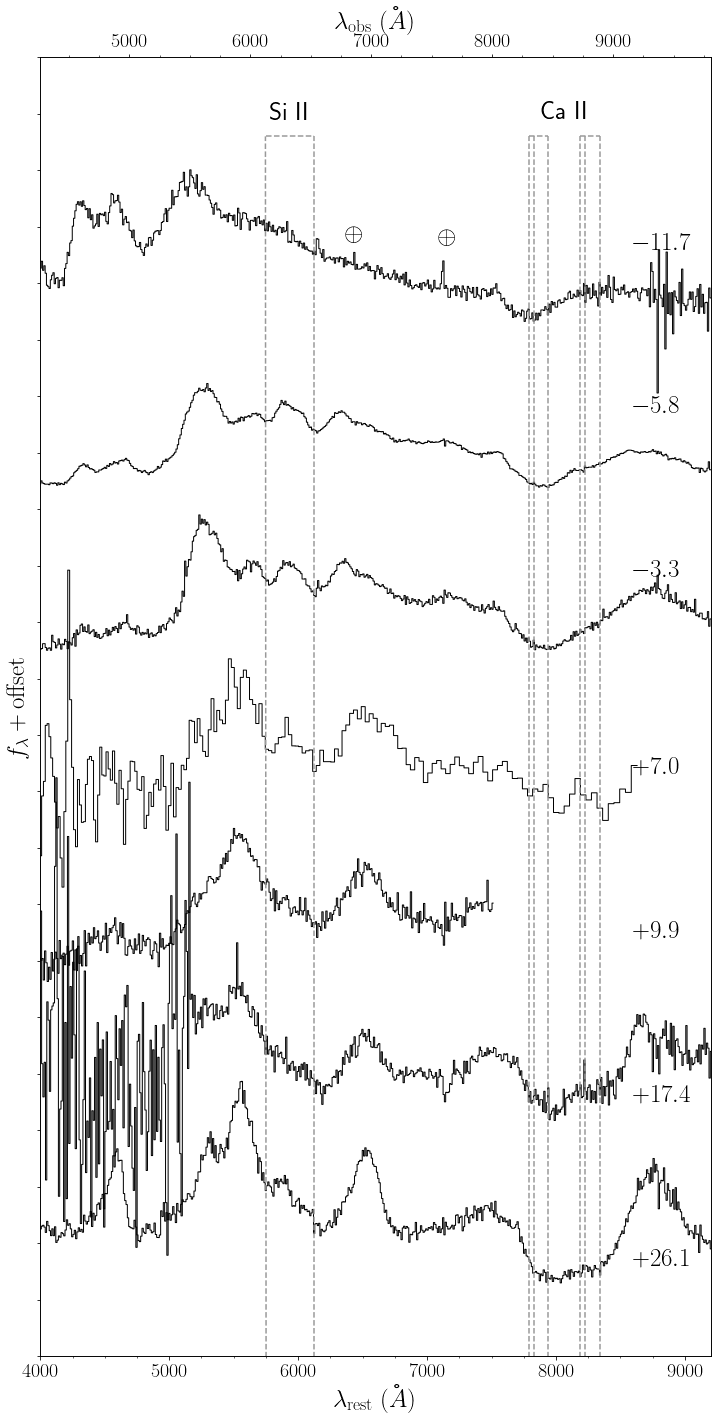

In [46]:
aam_colors = {
    'mustard': "#E29930",
    'blue': "#217CA3",
    'asphalt': "#32384D",
    'navy': "#444C5C",
    'punch': "#CE5A57",
    'ocean': "#78A5A3",
    'warm': "#E1B16A",
}

phase_list = []
mjd_list = []

fig, ax = plt.subplots(figsize=(10, 20))
spec_num = -1
for spec in spec_files[:-1]:
    if '0603' in spec:
        continue
    spec_num += 1
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)

    try:
        if 'Keck' in spec:
            fl_unc = spec_df[3].values
        else:
            fl_unc = spec_df[2].values

            if 'P60' in spec or 'P200' in spec:
                fl_unc **= .5
    except:
        warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
            spec_df[0].values)
    fl_unc0 = fl_unc.copy()

    out = data_binning(np.array([spec_df[0].values, spec_df[1].values,
                                 fl_unc]).T,
                       size=10)

    wv, fl = plot_box_spec(out[:, 0], out[:, 1])

    fl_unc = np.repeat(out[:, -1], 2)
    E = 10**(0.4 * calALambda(wv, rv, ebv))
    fl *= E

    norm_flux = np.nanmedian(fl[np.where((wv > 7200) & (wv < 7400))])
    ax.plot(wv / (1 + z),
            fl / norm_flux - 2.8 * spec_num,
            color='k',
            linewidth=1)

    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if 'MJD' in l:
            mjd_found = True
            if 'OBS' in l and '=' in l:  #Keck
                mjd_obs = float(l.split('=')[1].split("'")[1])
            elif '=' in l and 'at start' in l:
                mjd_obs = float(l.split('=')[1].split("'")[1])
            elif '=' in l and '/' in l:
                mjd_obs = float(l.split('=')[1].split('/')[0])
            elif '=' in l:
                mjd_obs = float(l.split('=')[1])
            elif ':' in l:
                mjd_obs = float(l.split(':')[1])
            break
    if not mjd_found:
        print('Warning: MJD-obs not found in {}!'.format(spec))
        print('Try the observation date.')
        year = 2018
        pos_dat = spec.find(str(year))
        year_obs = spec[pos_dat:pos_dat + 4]
        mon_obs = spec[pos_dat + 4:pos_dat + 6]
        date_obs = spec[pos_dat + 6:pos_dat + 8]
        mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs, date_obs)).mjd

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    phase_list.append(phase)
    mjd_list.append(mjd_obs)
    if mjd_obs < t_max_mjd:
        ax.text(8600, 1.6 - 2.9 * spec_num, r'$-{:.1f}$'.format(np.abs(phase)))
    else:
        ax.text(8600, 1 - 2.9 * spec_num, r'$+{:.1f}$'.format(np.abs(phase)))

ax.set_xlim(4000, 9200)
ax.set_ylim(-18, 5)
ax.set_yticklabels([])
ax.set_ylabel(r'$f_\lambda + \mathrm{offset}$')
ax.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$')
ax.xaxis.set_minor_locator(MultipleLocator(250))
ax.yaxis.set_major_locator(MultipleLocator(1))

wv_obs = ax.twiny()
wv_obs.set_xlim(np.array(ax.get_xlim()) * (1 + z))
wv_obs.set_xlabel(r'$\lambda_\mathrm{obs} \; (\AA)$')
wv_obs.xaxis.set_minor_locator(MultipleLocator(250))

# plot lines
# Si II 6355
ax.plot([6355 * (1 - 11000 / 2.9979e5), 6355 * (1 - 11000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
# Si II 5972
ax.plot([5972 * (1 - 11000 / 2.9979e5), 5965 * (1 - 11000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
# # Si II 5669
# ax.plot([5669*(1-19000/2.9979e5), *5670*(1-18000/2.9979e5)],
#         [-1.5,3.6], '--', color='0.6')
# # Si II 5047
# ax.plot([5047*(1-19000/2.9979e5), *5047*(1-18000/2.9979e5)],
#         [-1.6,3.6], '--', color='0.6')
ax.plot([5972 * (1 - 11000 / 2.9979e5), 6355 * (1 - 11000 / 2.9979e5)],
        [3.6, 3.6],
        '--',
        color='0.6')
ax.text(5937.346, 3.9, r'Si II', ha='center')

# Ca II 8498 - HV
ax.plot([8498 * (1 - 25000 / 2.9979e5), 8498 * (1 - 25000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
# Ca II 8542 - HV
ax.plot([8542 * (1 - 25000 / 2.9979e5), 8542 * (1 - 25000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
# Ca II 8662 - HV
ax.plot([8662 * (1 - 25000 / 2.9979e5), 8662 * (1 - 25000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
ax.plot([8498 * (1 - 25000 / 2.9979e5), 8662 * (1 - 25000 / 2.9979e5)],
        [3.6, 3.6],
        '--',
        color='0.6')

# Ca II 8498
ax.plot([8498 * (1 - 11000 / 2.9979e5), 8498 * (1 - 11000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
# Ca II 8542
ax.plot([8542 * (1 - 11000 / 2.9979e5), 8542 * (1 - 11000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
# Ca II 8662
ax.plot([8662 * (1 - 11000 / 2.9979e5), 8662 * (1 - 11000 / 2.9979e5)],
        [-26, 3.6],
        '--',
        color='0.6')
ax.plot([8498 * (1 - 11000 / 2.9979e5), 8662 * (1 - 11000 / 2.9979e5)],
        [3.6, 3.6],
        '--',
        color='0.6')
ax.text(8070, 3.9, r'Ca II', ha='center')

ax.text(7633 / (1 + z), 1.7, r'$\oplus$', ha='center')
ax.text(6867 / (1 + z), 1.75, r'$\oplus$', ha='center')

fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
#fig.savefig('../paper/figures/optical_spec_evolution.pdf')

# Line Velocity

In [10]:
date_list = (np.array(mjd_list) - t_max_mjd) / (1 + z)

In [28]:
SiII_vel = np.array(
    [np.nan, -10227, -10330, -9447, np.nan, np.nan, np.nan, np.nan, np.nan])
SiII_vel_sig = np.array([np.nan, 69, 98, 659, np.nan, np.nan, np.nan, np.nan, np.nan])

In [36]:
CaII_vel_pvf2 = np.array([np.nan, -9120, -10747, -5249, np.nan, np.nan, -4157, -6382, np.nan])
CaII_vel_pvf_sig2 = np.array([np.nan, 142, 1131, 515, np.nan, np.nan, 232, 336, np.nan])

CaII_vel_hvf2 = np.array([-27513, -24466, -25226, -20497, np.nan, np.nan, -19909, -22024, np.nan])
CaII_vel_hvf_sig2 = np.array([257, 62, 635, 970, np.nan, np.nan, 283, 451, np.nan])

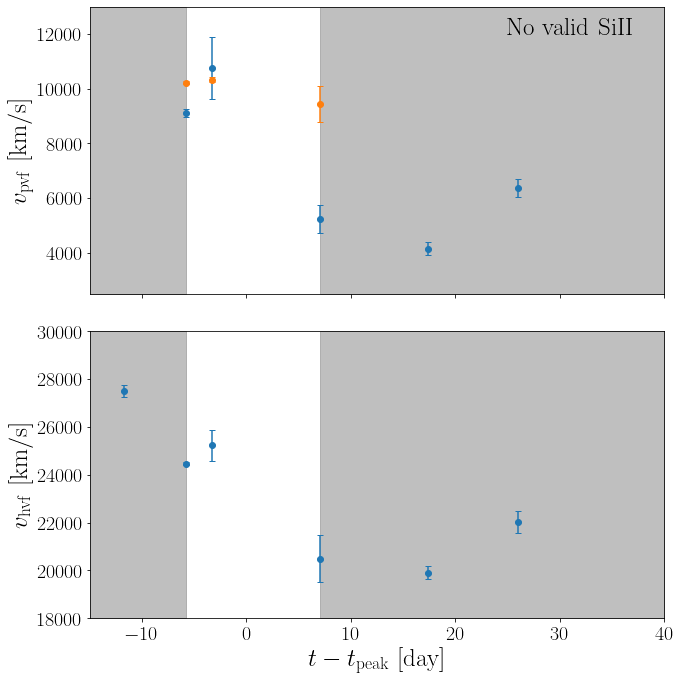

In [37]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ylim1 = [2500, 13000]
ylim2 = [18000, 30000]

ax[0].errorbar(date_list,
               -CaII_vel_pvf2,
               yerr=CaII_vel_pvf_sig2,
               fmt='o',
               capsize=3)
ax[0].errorbar(date_list, -SiII_vel, yerr=SiII_vel_sig, fmt='o', capsize=3)

ax[1].errorbar(date_list,
               -CaII_vel_hvf2,
               yerr=CaII_vel_hvf_sig2,
               fmt='o',
               capsize=3)
valid_SiII = np.argwhere(~np.isnan(SiII_vel)).flatten()
for a, ylim in zip(ax, [ylim1, ylim2]):
    a.fill_betweenx(
        ylim, [date_list[valid_SiII[-1]], date_list[valid_SiII[-1]]],
        [date_list[-1], date_list[-1]],
        color='grey',
        alpha=0.5)
    a.fill_betweenx(
        ylim,
        [date_list[valid_SiII[0] - 1] - 5, date_list[valid_SiII[0] - 1] - 5],
        [date_list[1], date_list[1]],
        color='grey',
        alpha=0.5)
ax[0].set_ylabel(r'$v_\mathrm{pvf}\ [\mathrm{km/s}]$')
ax[1].set_ylabel(r'$v_\mathrm{hvf}\ [\mathrm{km/s}]$')
ax[1].set_xlabel(r'$t-t_\mathrm{peak}\ [\mathrm{day}]$')
ax[0].set_ylim(ylim1)
ax[1].set_ylim(ylim2)
ax[1].set_xlim(-15, 40)
ax[0].text(25, 12000, r'$\mathrm{No\ valid\ SiII}$')
plt.tight_layout()

# ZTF Magnitude

In [12]:
filter_g = np.loadtxt('../lc/response/Palomar_ZTF.g.dat')
filter_r = np.loadtxt('../lc/response/Palomar_ZTF.r.dat')

In [13]:
def filter_band(filt, wv):
    wv_range = filt[:, 0]
    response = filt[:, 1]
    if wv < wv_range[0] or wv > wv_range[-1]:
        return 0
    arg = np.argwhere(wv_range >= wv).flatten()[0]
    try:
        slope = (response[arg] - response[arg - 1]) / (wv_range[arg] - wv_range[arg - 1])
        return slope * (wv - wv_range[arg]) + response[arg]
    except:
        print(wv_range[arg], response[arg])
        return np.nan

In [14]:
def integrate(y, x):
    s = 0
    ds0 = 0
    for i in range(len(x)-1):
        ds = (x[i + 1] - x[i]) * (y[i + 1] + y[i]) / 2
        if np.isnan(ds):
            ds = ds0
        s += ds
        ds0 = ds
    return s

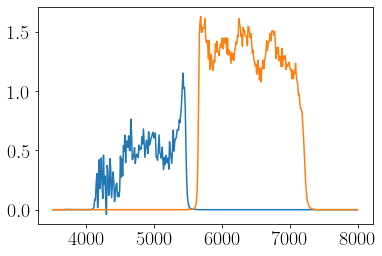

./ZTF18aaqeasu_20180514_Keck1_v1.ascii -5.662221999999019 1.3157875639323278


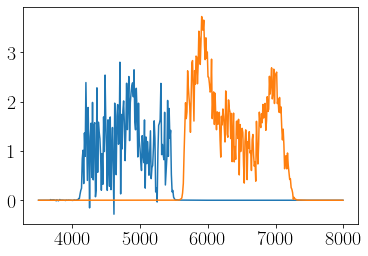

./ZTF18aaqeasu_20180617_Keck1_v1.ascii 28.268121000000974 0.6887855209644255


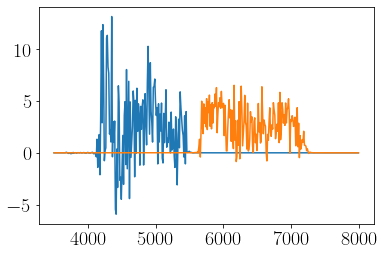

./ZTF18aaqeasu_20180713_Keck1_v1.ascii 54.30709999999817 0.27347017012080616


In [19]:
from astropy.stats import mad_std

t, gr, gr_unc = [], [], []

tfl = 58258

spec_num = -1
for spec in spec_files:
    if 'GNIRS' in spec:
        continue
    spec_num += 1
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)

    try:
        if 'Keck' in spec:
            fl_unc = spec_df[3].values
        else:
            fl_unc = spec_df[2].values

            if 'P60' in spec or 'P200' in spec:
                fl_unc **= .5
    except:
        continue
        '''warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
            spec_df[0].values)'''

    out = data_binning(np.array([spec_df[0].values, spec_df[1].values,
                                 fl_unc]).T,
                       size=10)
    wv = out[:, 0]
    fl = out[:, 1]
    arg = np.where((wv < 8000) & (wv > 3500))
    fl = fl[arg]
    fl_unc = fl_unc[arg]
    wv = wv[arg]
    
    fl *= 10**(0.4 * calALambda(wv, rv, ebv))
    fl_unc *= 10**(0.4 * calALambda(wv, rv, ebv))
    norm_flux = np.nanmedian(fl[np.where((wv > 7200) & (wv < 7400))])

    gFlux, rFlux = [], []
    for i in range(500):
        gband = (fl + fl_unc * np.random.randn(len(fl))) * np.array(
            [filter_band(filt=filter_g, wv=w) for w in wv]) / norm_flux
        rband = (fl + fl_unc * np.random.randn(len(fl))) * np.array(
            [filter_band(filt=filter_r, wv=w) for w in wv]) / norm_flux
        #plt.plot(wv, gband, color='darkgreen')
        #plt.plot(wv, rband, color='crimson')
        gflux = integrate(gband, wv)
        rflux = integrate(rband, wv)
        gFlux = np.append(gFlux, gflux)
        rFlux = np.append(rFlux, rflux)
        #plt.show()
        #break
    plt.plot(wv, gband)
    plt.plot(wv, rband)
    plt.show()
    #plt.hist(gFlux, bins=20, histtype='step')
    #plt.hist(rFlux, bins=20, histtype='step')
    g_r = -2.5 * np.log10(gFlux / rFlux)
    #plt.hist(g_r, histtype='step', bins=50)
    #plt.show()
    t = np.append(t, mjd_list[spec_num] - tfl)
    gr = np.append(gr, np.mean(g_r))
    gr_unc = np.append(gr_unc, mad_std(g_r))

    print(spec, mjd_list[spec_num] - tfl,
          -2.5 * np.log10(np.mean(gFlux) / np.mean(rFlux)))